## Notebook for NaI Array Calibration
Alya Sharbaugh, Anthony Villano, University of Colorado Denver

In [1]:
# Import libraries

import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel,LinearModel

#import hist
#from hist import Hist
#from tabulate import tabulate


### Functions for Plots and Fits

In [2]:
# Define Gaussian distribution function

def Gauss(x, a, x0, sigma): 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 


In [3]:
# Define function for plotting histograms

def PlotHist(name,data,bins):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    
    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    
    plt.show()
    

In [5]:
# Define function for plotting histograms with fit

def PlotFit(name,bins,data,bins1,fit1,bins2,fit2):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    ax.plot(bins1,fit1,'g--',label='Peak Fit')
    ax.plot(bins2,fit2,'r--',label='Peak Fit')

    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    ax.legend(loc=1,prop={'size':12})
    
    plt.show()
    

### Background Calibration

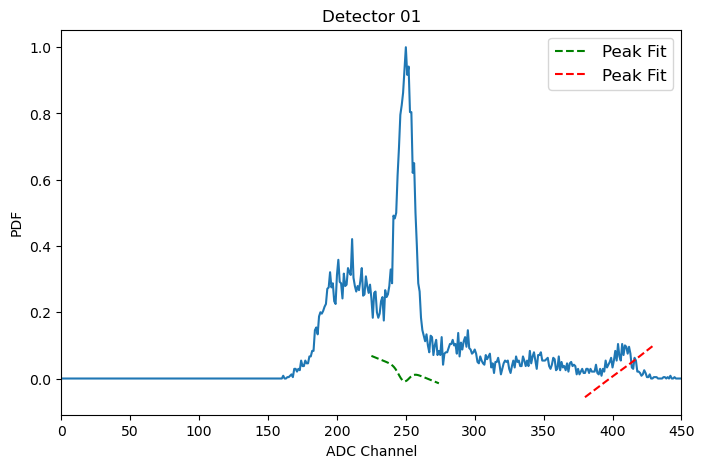

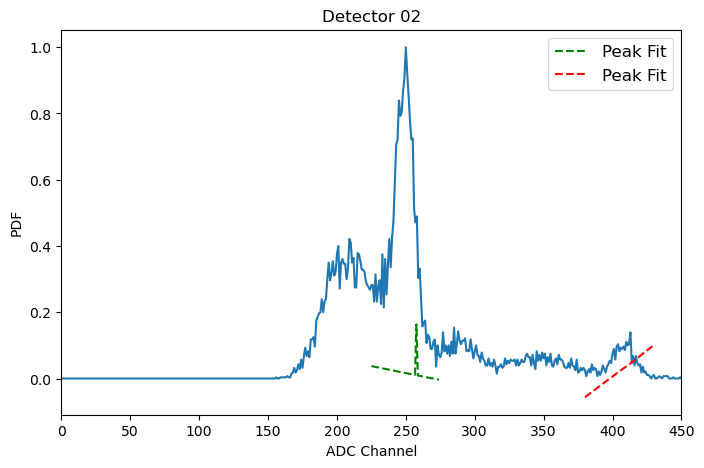

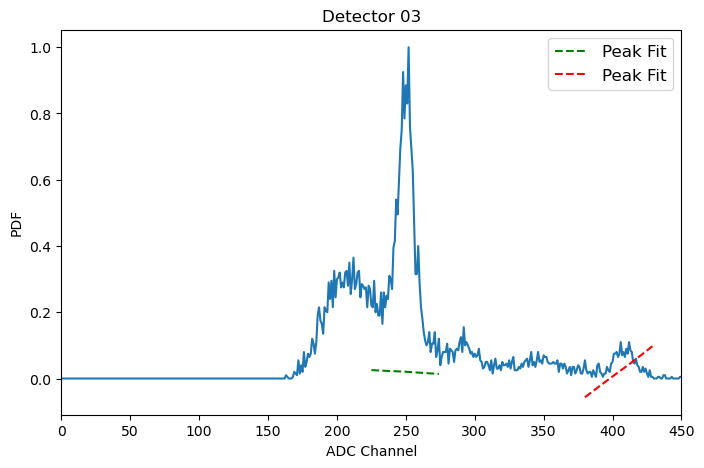

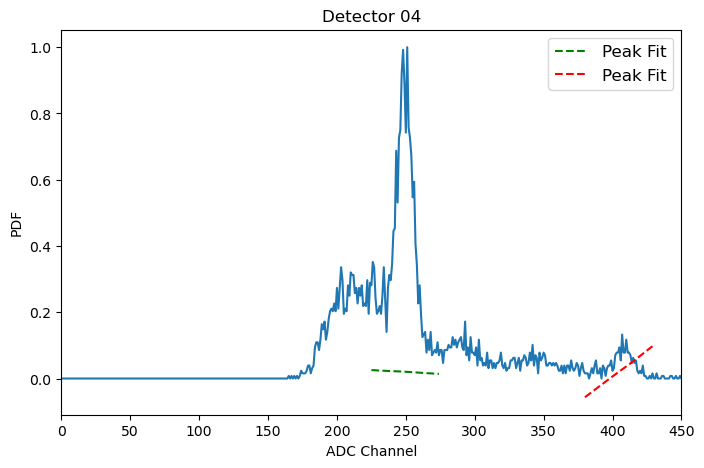

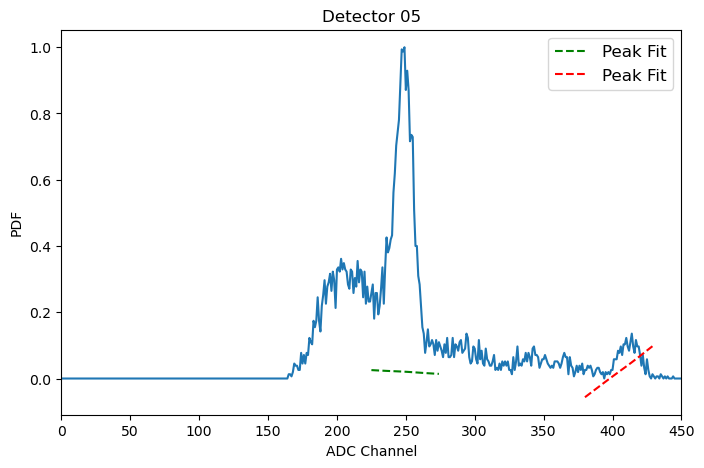

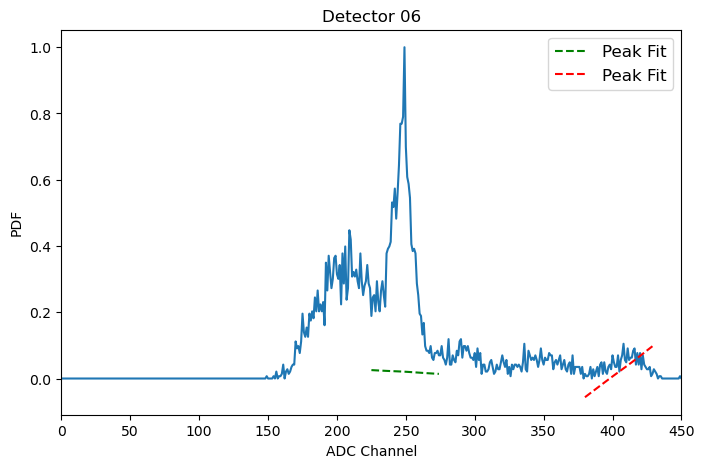

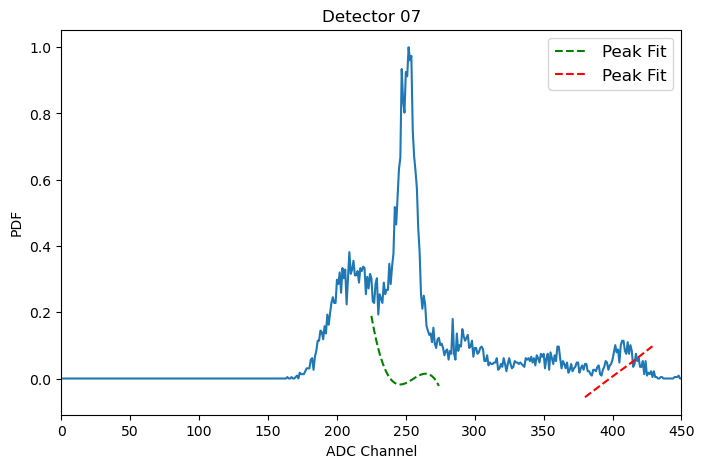

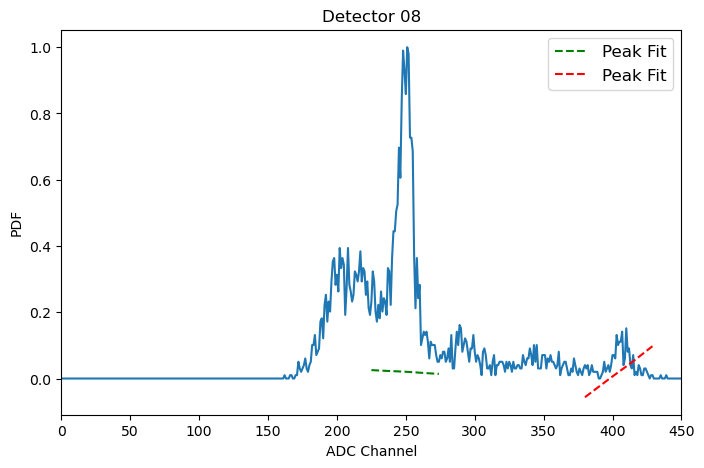

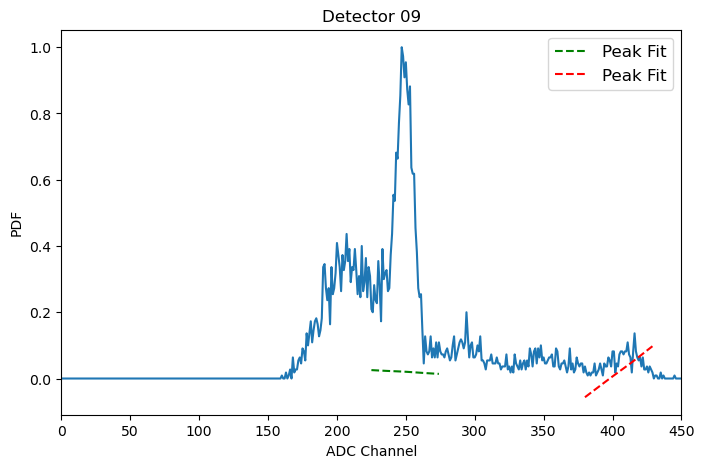

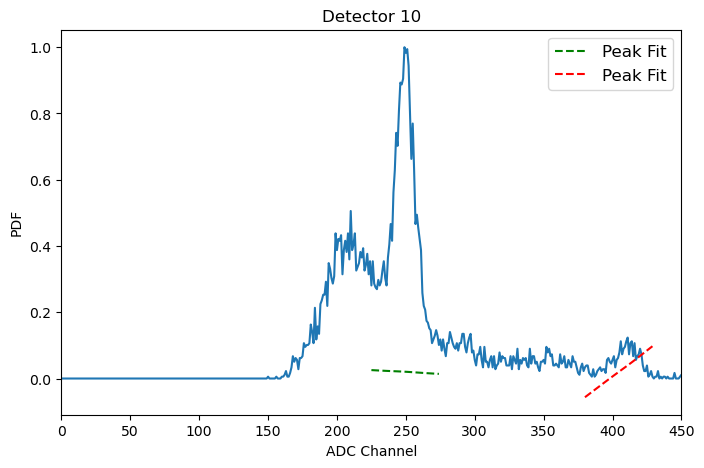

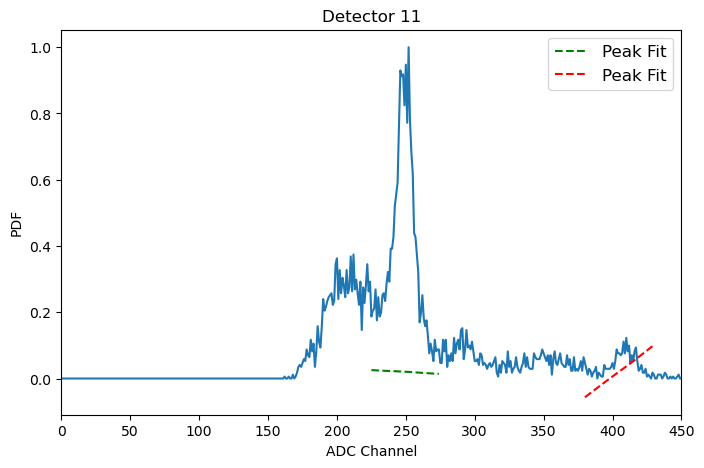

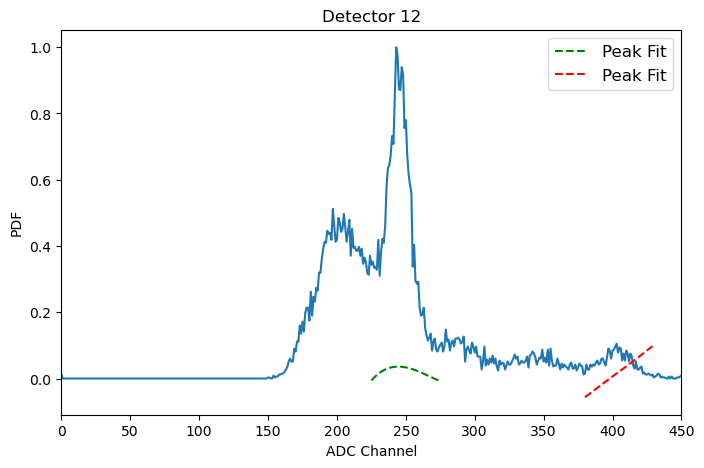

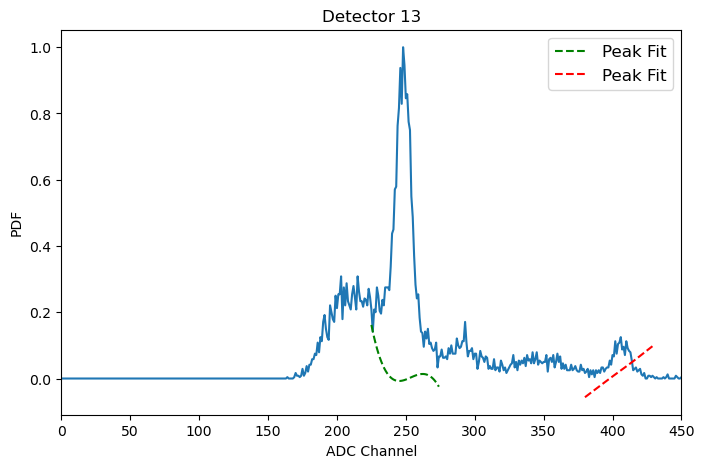

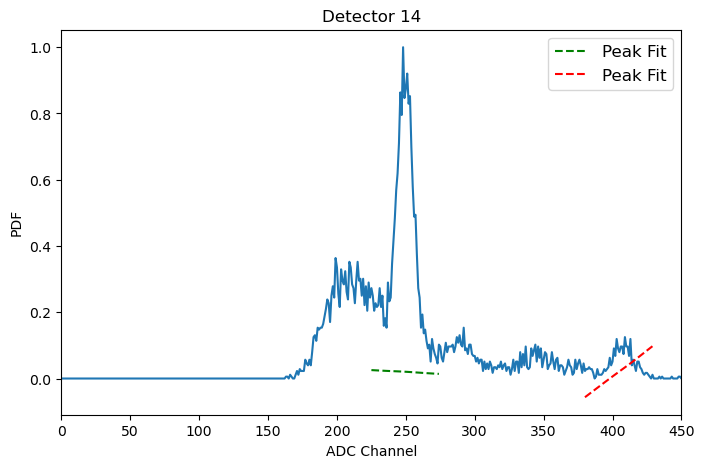

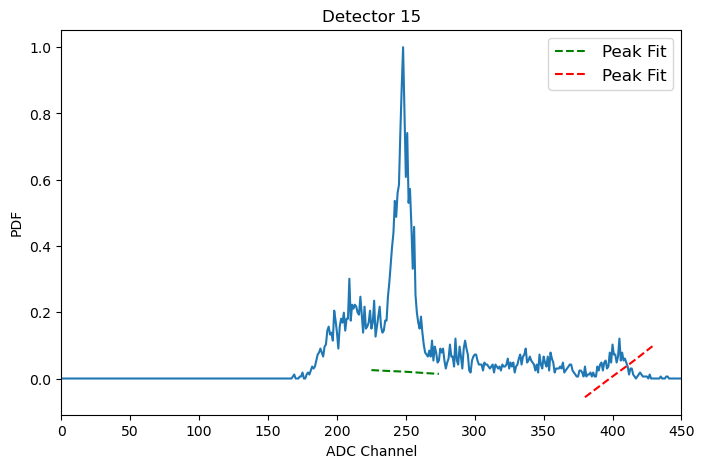

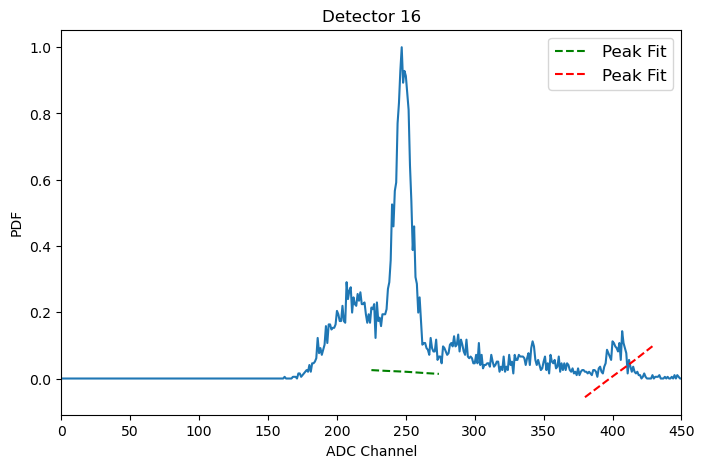

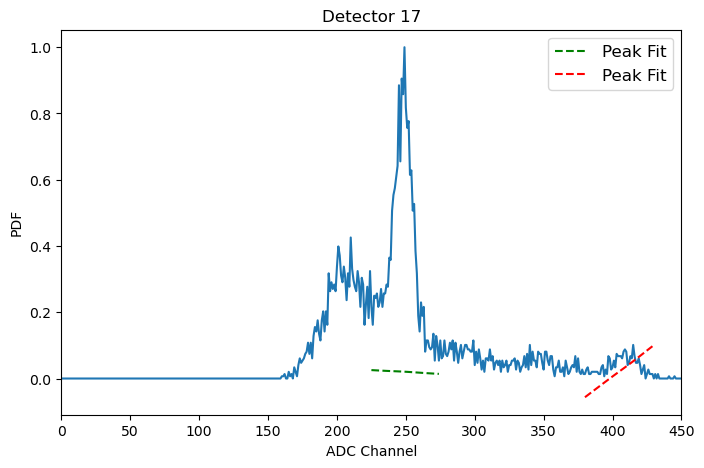

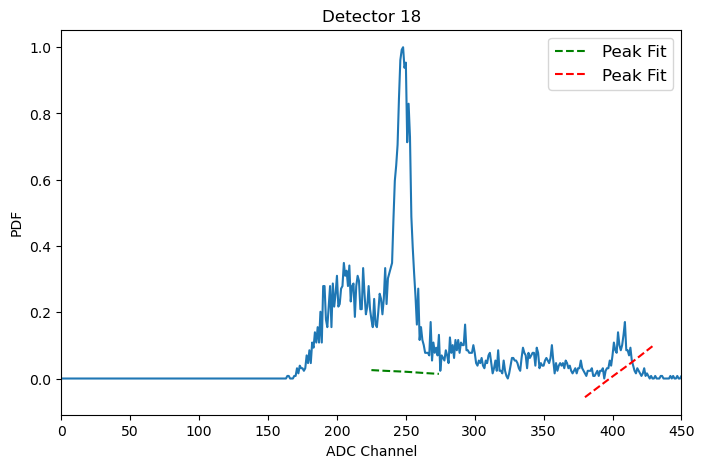

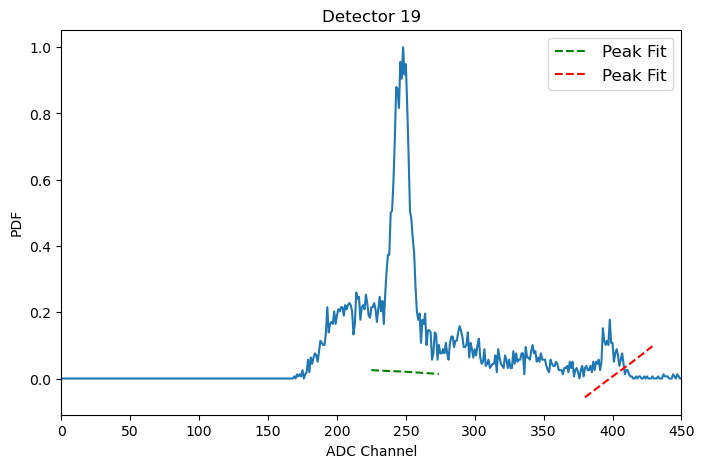

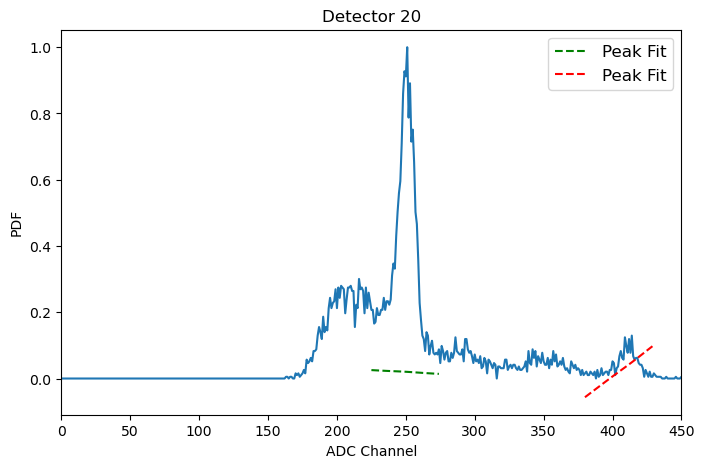

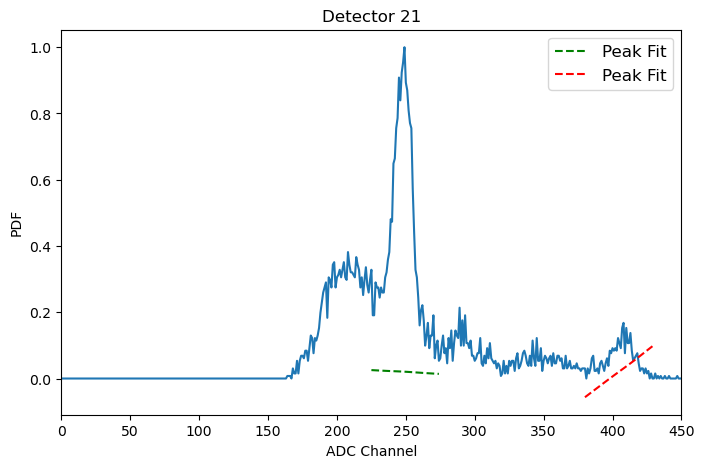

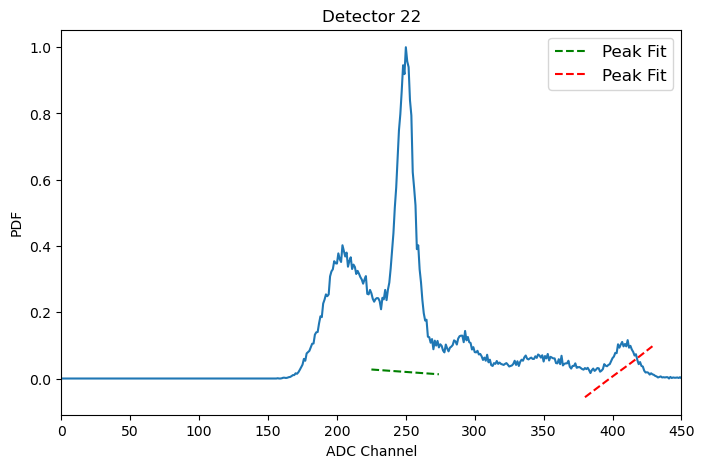

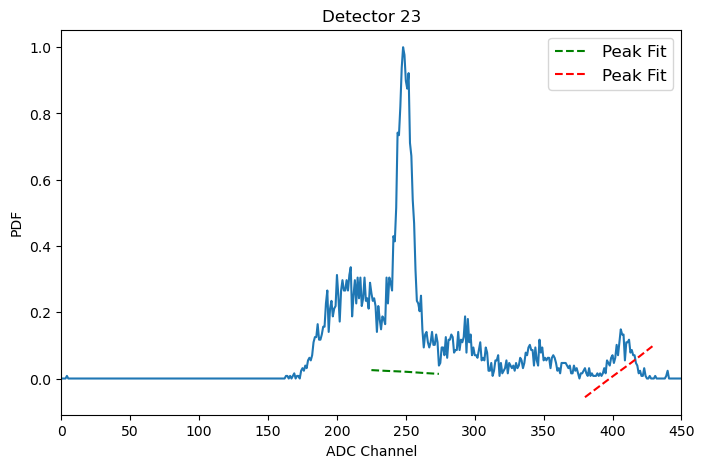

In [6]:
# Read in data from ROOT files and plot

directory = os.fsencode("Bknd_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Bknd_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        bknd = file["Energy/_F_EnergyCH0@DT5751_626"]
        bkndData,bins = bknd.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        bkndNorm = (bkndData - bkndData.min())/ (bkndData.max() - bkndData.min())   # Normalize since inconsistent counts

        #PlotHist(filename,bkndNorm,bins)

        bins1 = np.linspace(225,275,50)
        bins2 = np.linspace(380,430,50)

        ##################################
        #        SCIPY FITTING
        ##################################

        popt1, pcov1 = curve_fit(Gauss,bins1,bkndNorm[225:275],p0=[1,250,6])
        popt2, pcov2 = curve_fit(Gauss,bins2,bkndNorm[380:430],p0=[0.1,415,8])

        bestFit1 = Gauss(bins1,popt1[0],popt1[1],popt1[2])
        bestFit2 = Gauss(bins2,popt2[0],popt2[1],popt2[2])

        ##################################
        #        PLOT THE FIT
        ##################################

        PlotFit(filename,bins,bkndNorm,bins1,bestFit1,bins2,bestFit2)   # Plot normalized curve with fits
    

### Na-22 Calibration

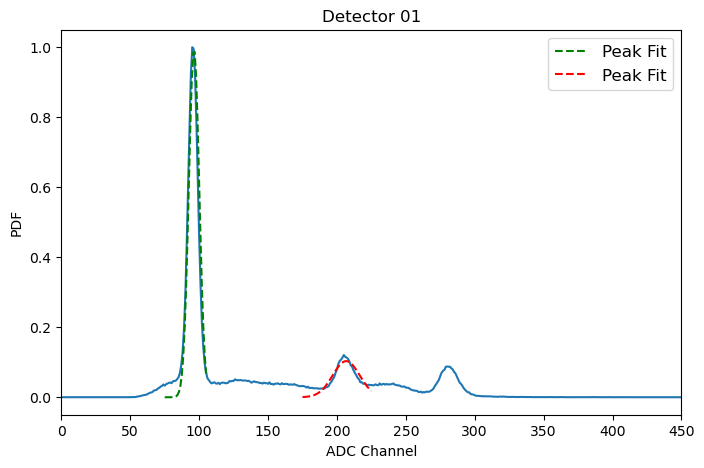

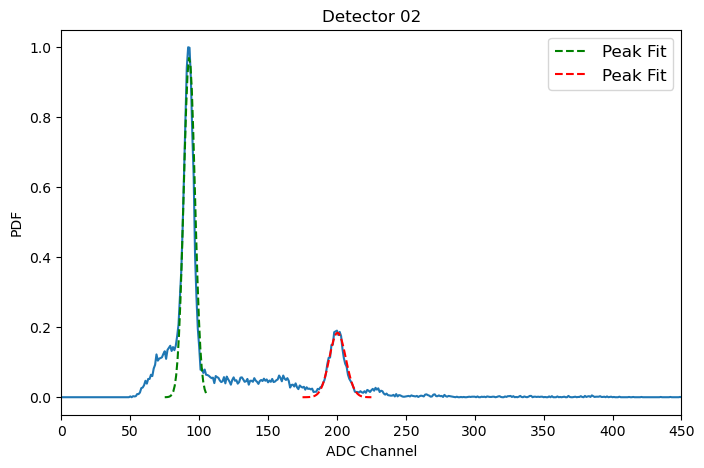

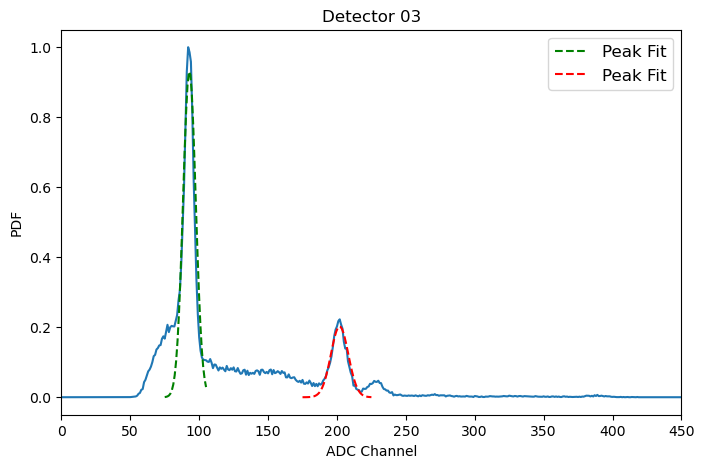

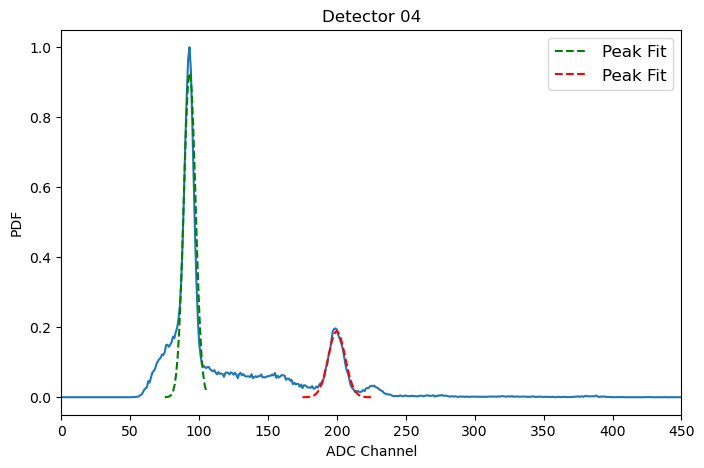

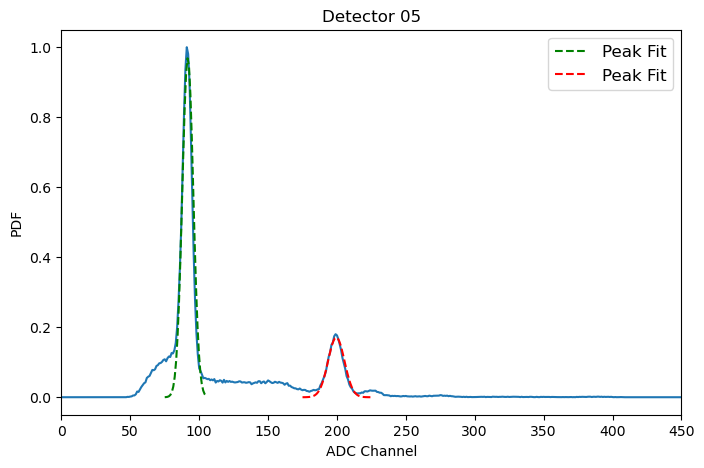

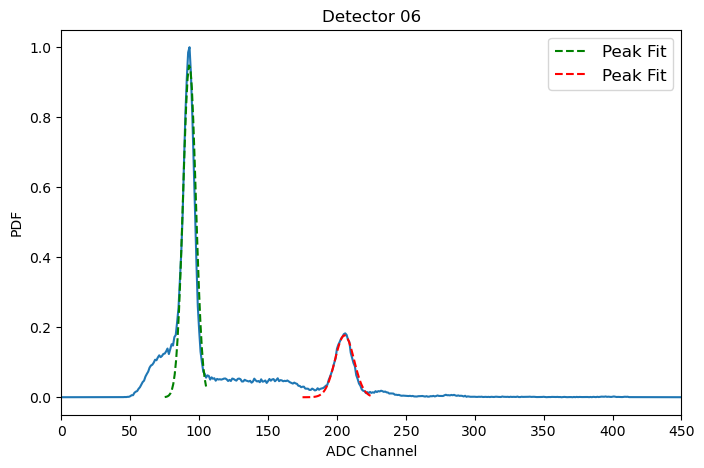

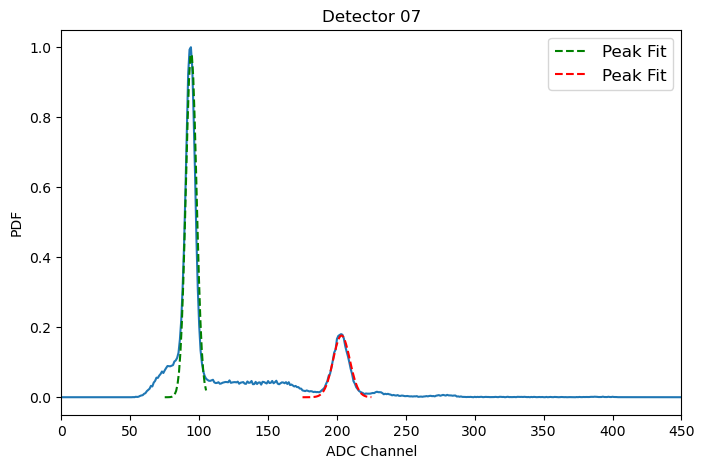

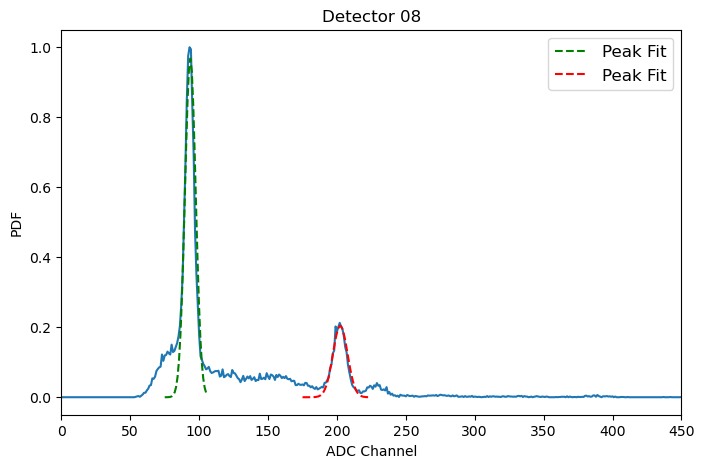

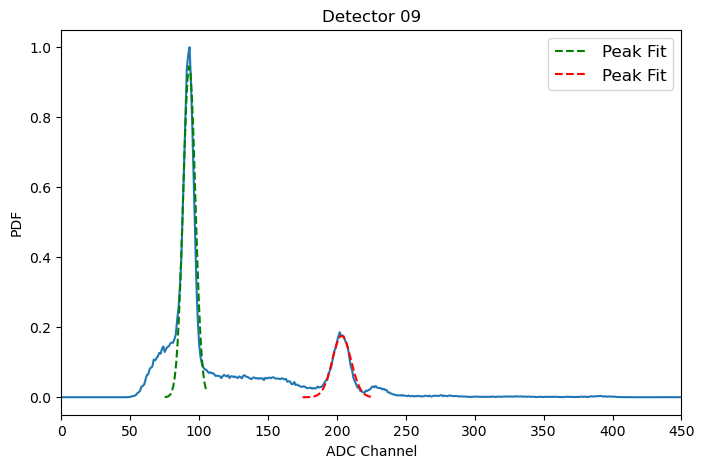

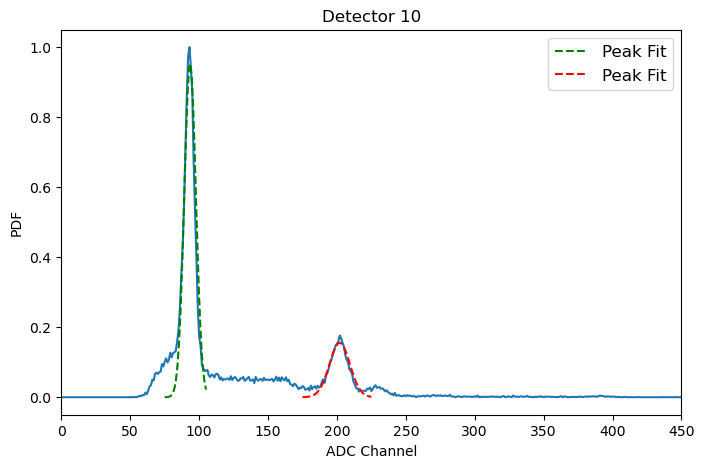

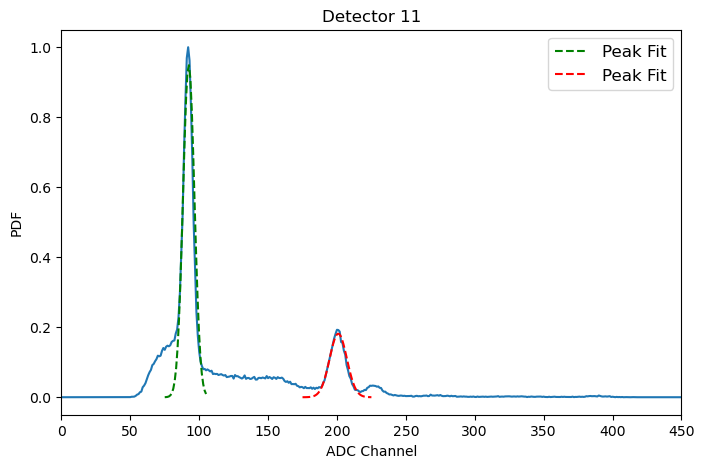

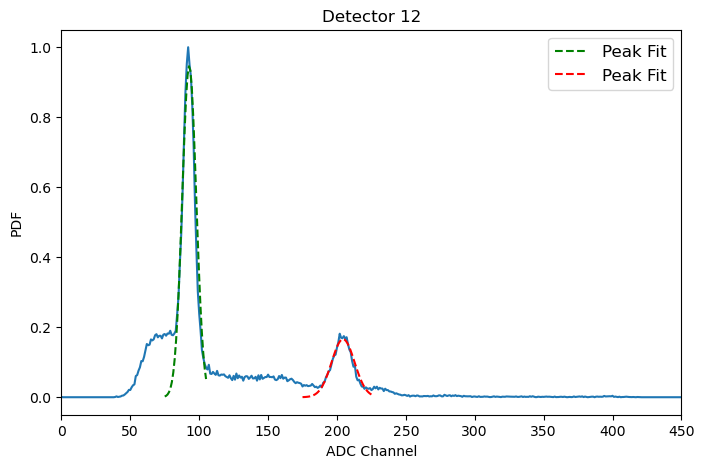

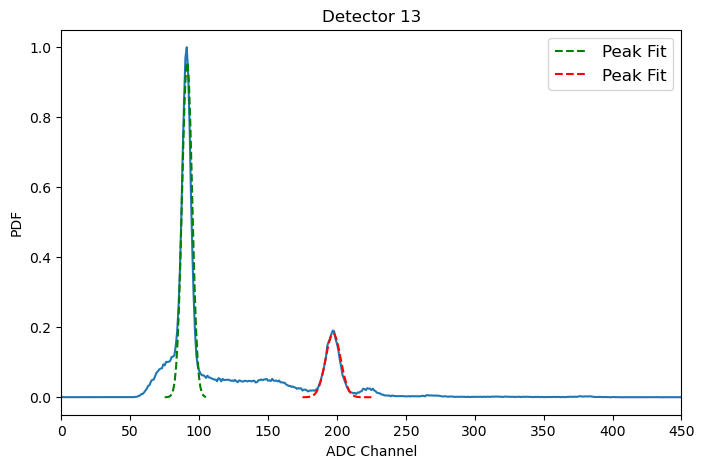

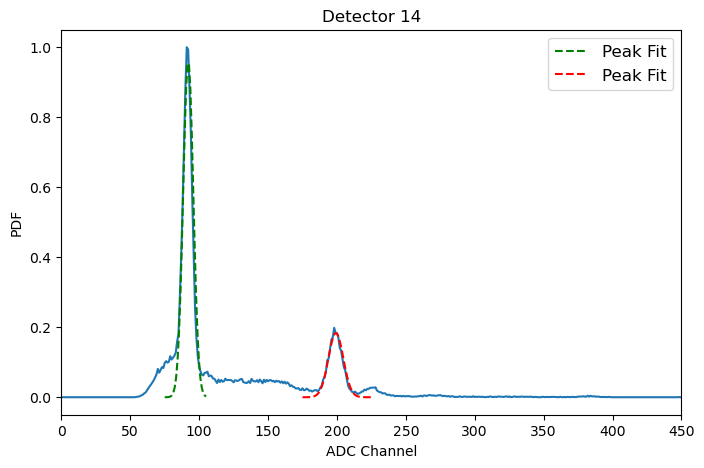

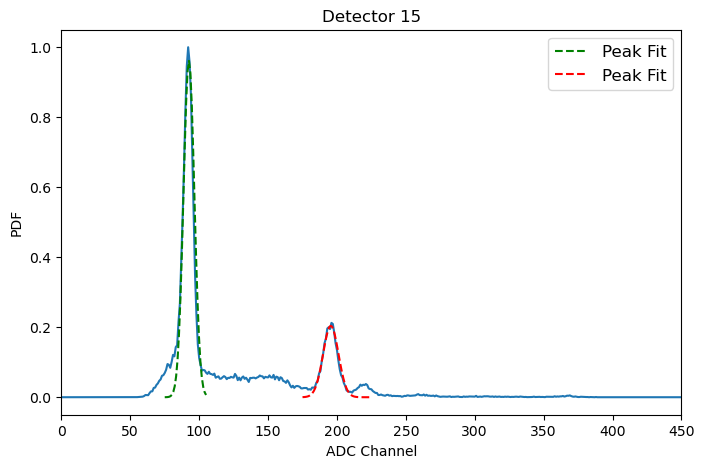

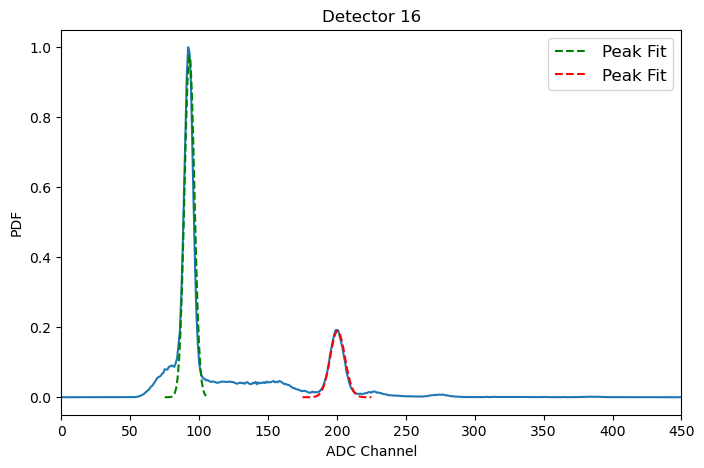

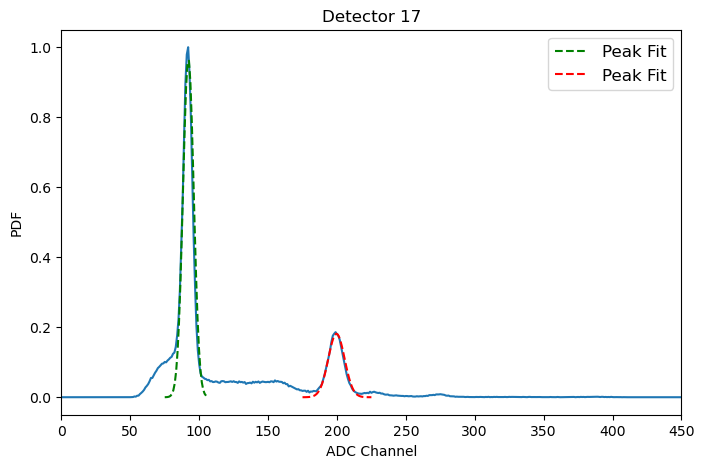

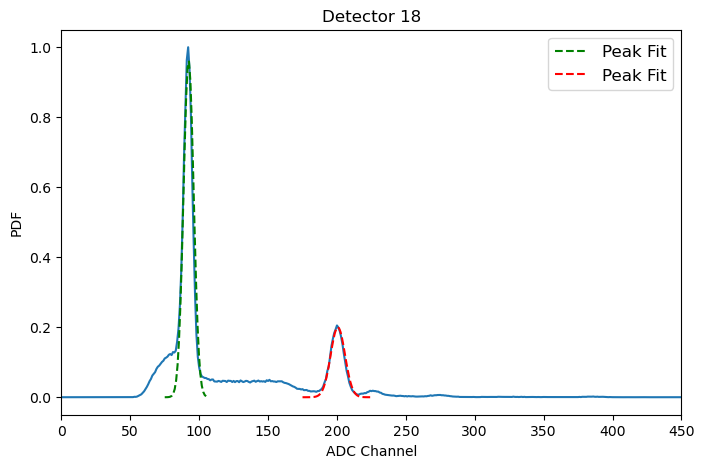

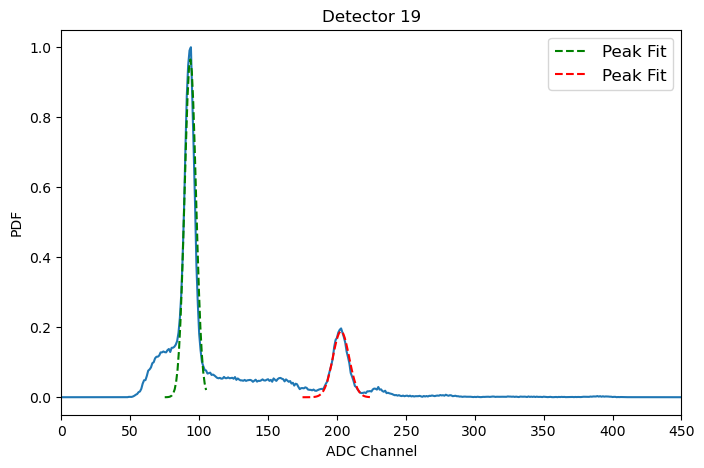

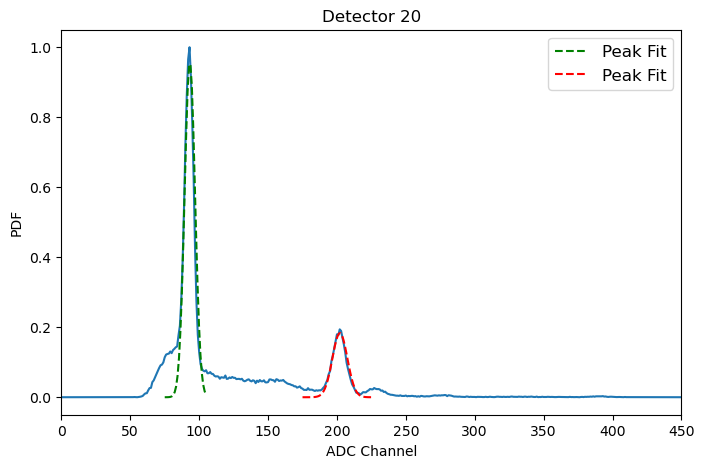

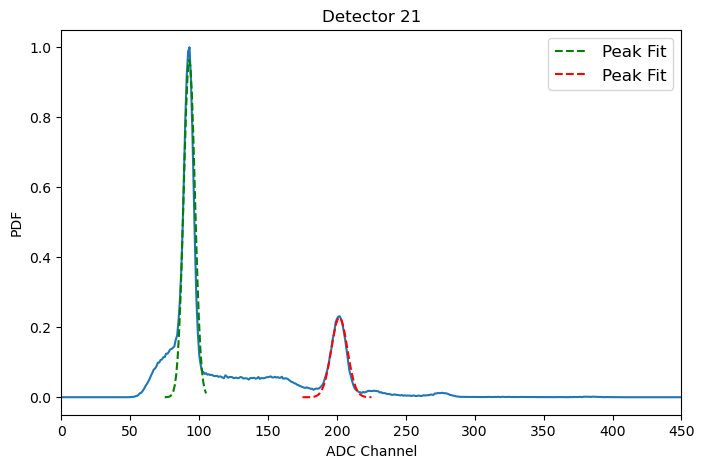

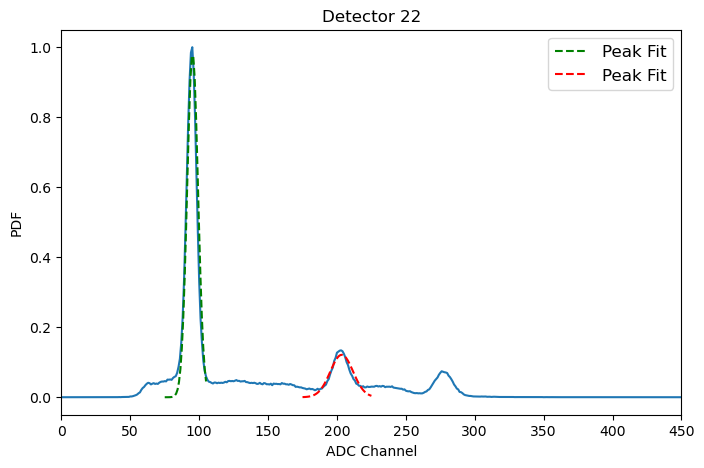

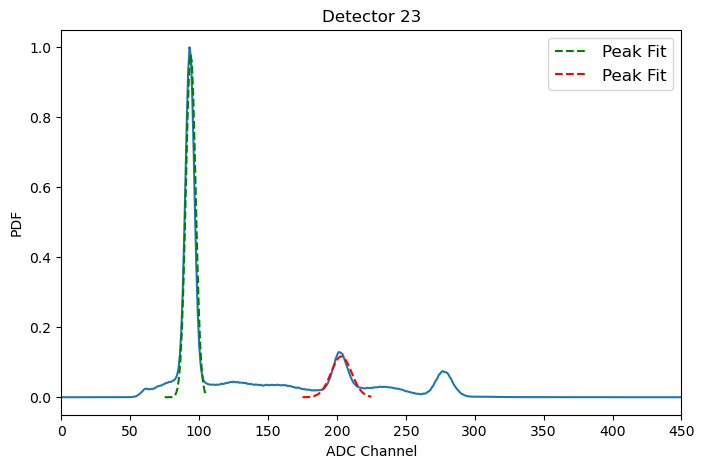

In [7]:
#### Read in data from ROOT files and plot

directory = os.fsencode("Na22_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Na22_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        Na22 = file["Energy/_F_EnergyCH0@DT5751_626"]
        Na22Data,bins = Na22.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        Na22Norm = (Na22Data - Na22Data.min())/ (Na22Data.max() - Na22Data.min())   # Normalize since inconsistent counts
        
        #PlotHist(filename,Na22Norm,bins)

        bins1 = np.linspace(75,105,30)
        bins2 = np.linspace(175,225,50)

        popt1, pcov1 = curve_fit(Gauss,bins1,Na22Norm[75:105],p0=[1,92,3])
        popt2, pcov2 = curve_fit(Gauss,bins2,Na22Norm[175:225],p0=[0.2,200,6])

        bestFit1 = Gauss(bins1,popt1[0],popt1[1],popt1[2])
        bestFit2 = Gauss(bins2,popt2[0],popt2[1],popt2[2])

        PlotFit(filename,bins,Na22Norm,bins1,bestFit1,bins2,bestFit2)   # Plot normalized curve with fits
        

In [ ]:
Extra Fitting Code for Manual Fits or More Accurate Lmfit (couldn't quite get working)

        ##################################
        #        MANUAL FITTING
        ##################################

        bestFit1 = Gauss(bins1,1,250,6)   # Fit the channel 250 peak
        bestFit2 = Gauss(bins2,0.1,415,8)   # Fit the channel 400 peak

        ##################################
        #        LMFIT FITTING
        ################################### 

        # Define function for fitting peaks to a Gaussian distrubution

        def FitHist(data,bins,cen,amp,yint,slp):

            peak = GaussianModel()
            background = LinearModel()
            mod = peak + background
        
            counts, bin_edges = np.histogram(data,bins=bins)
            bin_widths = np.diff(bin_edges)
            x = bin_edges[:-1] + (bin_widths/2)
            y = counts
            
            #pars = background.make_params(intercept=yint,slope=slp)
            pars = background.guess(y,x=x,intercept=yint,slope=slp)
            pars += peak.guess(y,x=x,center=cen,amplitude=amp)
            final_fit = mod.fit(y,pars,x=x)
            #final_fit.plot_fit()
           
            center = final_fit.params['center'].value
            #center_err = final_fit.params['center'].stderr
            width = final_fit.params['fwhm'].value
            #width_err = final_fit.params['fwhm'].stderr
        
            return final_fit   # bins,center,width

        # Implement function

        fit1 = FitHist(bkndData[225:275],bins1,250,1,0.3,-1)
        fit2 = FitHist(bkndData[380:430],bins2,415,0.1,0,0)

        print(fit1.fit_report())

        bestFit1 = fit1.best_fit
        bestFit2 = fit2.best_fit

        bins1 = bins1[:-1]
        bins2 = bins2[:-1]

        bestFit1 = fit1.best_fit/np.sum(fit1.best_fit)/np.diff(bins1)[0]
        bestFit2 = fit2.best_fit/np.sum(fit2.best_fit)/np.diff(bins2)[0]
